In [123]:
# Importing require libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import time
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



#Data Preprocessing
The below code contain storing the path of data and its labels, splitting the data into train, val and testset. The data is well shuffled and it stratified based on labels. The test data contain 20% of data and the train data is further splitted into training and validation set in 90%-10% respectively.

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
path="/content/drive/MyDrive/Dataset/Lab's"

In [126]:
#Lab's contain 3 folder named CRPF, BSF, J&K Police
military = {"crpf":0, "bsf":1, "j&k":2}

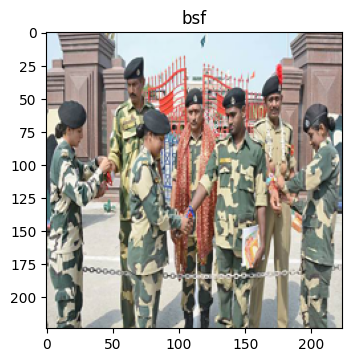

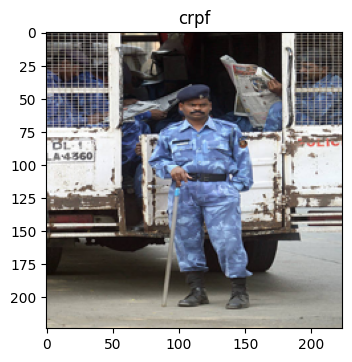

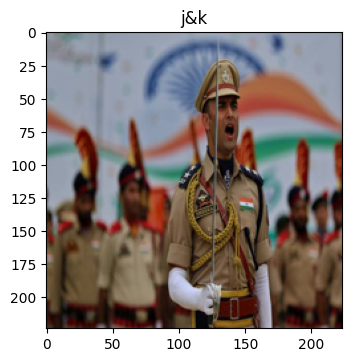

In [127]:
#storing the image directory path and labels
images=[]
labels=[]
for i, class_folder in enumerate(os.listdir(path)):
  class_path = os.path.join(path, class_folder)

  size = (224, 224)
  plt.figure(figsize=(13,7))
  plt.subplot(1,3,i+1)
  for j,files in enumerate(os.listdir(class_path)):
    image_path = os.path.join(class_path, files)
    images.append(image_path)
    labels.append(military[class_folder])
    if j==0:
      img=Image.open(os.path.join(class_path, files))
      img=img.resize(size)
      plt.title(f'{class_folder}')
      plt.imshow(img)



In [128]:
# Total datapoints
len(images), len(labels)

(500, 500)

In [129]:
#Splitting the data into train and testset
train_data, test_X, train_label, test_y=train_test_split(images, labels,test_size=0.2, random_state=41, shuffle=True, stratify=labels)

In [130]:
#Splitting the train data into trainset and validation set.
train_X, val_X, train_y, val_y=train_test_split(train_data, train_label,test_size=0.1, random_state=41, shuffle=True, stratify=train_label)

In [131]:
len(train_X), len(train_y)

(360, 360)

In [132]:
len(val_X), len(val_y)

(40, 40)

In [133]:
len(test_X), len(test_y)

(100, 100)

#Creating dataset and dataloader
The below code is a custom dataset loader, It sequentially load images and label. It does the necessary image transformation such as reshaping, converting into tensor and normalizing. The below code also have the option to increase the training dataset by doing transformation like rotation, scaling, flipping and color variation to make variation in the dataset and make the model more robust. Here I have commented that code becuause I don't see much significant in the result. I use normal traning, validation and test dataset without increasing the dataset. The created dataset is fed to Dataloader to make into batches.  

In [134]:


class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.path = path
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

In [135]:



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#uncomment the below code the increase the training set

# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# train_original = CustomDataset(train_X, train_y, transform=transform)
# train_augmented = CustomDataset(train_X, train_y, transform=train_transform)
# train_dataset = torch.utils.data.ConcatDataset([train_original, train_augmented])

train_dataset = CustomDataset(train_X, train_y, transform=transform)
val_dataset = CustomDataset(val_X, val_y, transform=transform)
test_dataset = CustomDataset(test_X, test_y, transform=transform)


In [136]:
len(train_dataset), len(val_dataset), len(test_dataset)

(360, 40, 100)

In [137]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Defining Model
The model defined below is a pretrained VGG16 model. The last layer is changed to incorporate the number of class that is there for this task. The model is fined tuined completely to learn features for this particular task.
The loss function that is used here is crossEntropy loss and the optimizer is Adam with learning rate 1e-5.

In [138]:

# def define_model():
#   pretrain_model = models.resnet18(pretrained=True)
#   num_features = pretrain_model.fc.in_features
#   pretrain_model.fc = nn.Linear(num_features, 3)
#   return pretrain_model


In [139]:
# def define_model():
#     pretrained_model = models.resnet50(pretrained=True)
#     num_features = pretrained_model.fc.in_features
#     pretrained_model.fc = nn.Linear(num_features, 3)
#     return pretrained_model

In [140]:
def define_model():
    pretrained_model = models.vgg16(pretrained=True)
    num_features = pretrained_model.classifier[6].in_features
    pretrained_model.classifier[6] = nn.Linear(num_features, 3)
    return pretrained_model

In [141]:
pretrain_model = define_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [142]:
optimizer = optim.Adam(pretrain_model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pretrain_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Model Traning and validation
The model is trained for 60 epoch. The validation set for the model is to tune the hyperparamer and also track the validation loss to avoid overfitting. Here early stopping is employed every 10 epoch to avoid overfitting. The plot for training, validation loss and accuracy is added below. The model is test on datapoint more then 100 from all three class. The peak accuracy that I got is 86%. The confusion matrix for the test set is also plotted.

In [144]:
def train_model2(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []


    best_val_loss = float('inf')
    best_model_state_dict = None
    no_improvement_epochs = 0
    early_stopping_epochs = 10
    early_stopping_bool=False
    progress_bar = tqdm(total=num_epochs, desc='Training', unit='epoch')
    model.train()
    for epoch in range(num_epochs):
      start_time = time.time()
      model.train()
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      for batch_X, batch_y in train_loader:
          optimizer.zero_grad()
          batch_X=batch_X.to(device)
          batch_y=batch_y.to(device)
          outputs = model(batch_X)
          loss = criterion(outputs, batch_y.long())
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          train_total += batch_y.size(0)
          train_correct += (predicted == batch_y).sum().item()
      train_loss /= len(train_loader)
      train_accuracy = train_correct / train_total

      # Validation
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      with torch.no_grad():
          for batch_X, batch_y in val_loader:
              batch_X=batch_X.to(device)
              batch_y=batch_y.to(device)
              outputs = model(batch_X)
              _, predicted = torch.max(outputs.data, 1)
              val_total += batch_y.size(0)
              val_correct += (predicted == batch_y).sum().item()
              val_loss += criterion(outputs, batch_y.long()).item()

      val_loss /= len(val_loader)
      val_accuracy = val_correct / val_total


      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_accuracies.append(train_accuracy)
      val_accuracies.append(val_accuracy)

      # Check if the current model performs better on validation set
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state_dict = model.state_dict()
          no_improvement_epochs = 0
      else:
          no_improvement_epochs += 1

      print("Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%"\
            .format(epoch+1, num_epochs, train_loss, train_accuracy * 100))
      print("Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%"\
            .format(epoch+1, num_epochs, val_loss, val_accuracy * 100))


      if no_improvement_epochs >= early_stopping_epochs:
          print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(early_stopping_epochs))
          early_stopping_bool=True
          break
      end_time = time.time()


      epoch_time = end_time - start_time

      progress_bar.set_postfix({'Elapsed Time': f'{epoch_time:.2f}s'})
      progress_bar.update()


    model.load_state_dict(best_model_state_dict)

    if early_stopping_bool==True:
      train_losses=train_losses[:-early_stopping_epochs]
      val_losses=val_losses[:-early_stopping_epochs]
      train_accuracies=train_accuracies[:-early_stopping_epochs]
      val_accuracies=val_accuracies[:-early_stopping_epochs]
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'b', label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()

    # Plotting the train accuracy and validation accuracy curves
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b', label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r', label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('accuracy_plot.png')
    plt.show()


    return model



In [145]:
# pretrain_model=train_model(pretrain_model, train_loader, optimizer, criterion, 30)



Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

Training:   0%|          | 0/60 [00:10<?, ?epoch/s, Elapsed Time=10.81s]

Training:   2%|▏         | 1/60 [00:10<10:38, 10.83s/epoch, Elapsed Time=10.81s]

Epoch [1/60], Training Loss: 1.1670, Training Accuracy: 31.94%
Epoch [1/60], Validation Loss: 1.0086, Validation Accuracy: 52.50%




Training:   2%|▏         | 1/60 [00:21<10:38, 10.83s/epoch, Elapsed Time=10.66s]

Training:   3%|▎         | 2/60 [00:21<10:22, 10.74s/epoch, Elapsed Time=10.66s]

Epoch [2/60], Training Loss: 0.9740, Training Accuracy: 52.50%
Epoch [2/60], Validation Loss: 0.9121, Validation Accuracy: 67.50%




Training:   3%|▎         | 2/60 [00:31<10:22, 10.74s/epoch, Elapsed Time=10.36s]

Training:   5%|▌         | 3/60 [00:31<10:02, 10.57s/epoch, Elapsed Time=10.36s]

Epoch [3/60], Training Loss: 0.8070, Training Accuracy: 72.78%
Epoch [3/60], Validation Loss: 0.8010, Validation Accuracy: 70.00%




Training:   5%|▌         | 3/60 [00:42<10:02, 10.57s/epoch, Elapsed Time=10.85s]

Training:   7%|▋         | 4/60 [00:42<09:58, 10.69s/epoch, Elapsed Time=10.85s]

Epoch [4/60], Training Loss: 0.6270, Training Accuracy: 78.06%
Epoch [4/60], Validation Loss: 0.6367, Validation Accuracy: 80.00%




Training:   7%|▋         | 4/60 [00:53<09:58, 10.69s/epoch, Elapsed Time=10.88s]

Training:   8%|▊         | 5/60 [00:53<09:51, 10.76s/epoch, Elapsed Time=10.88s]

Epoch [5/60], Training Loss: 0.4145, Training Accuracy: 87.50%
Epoch [5/60], Validation Loss: 0.5997, Validation Accuracy: 77.50%




Training:   8%|▊         | 5/60 [01:04<09:51, 10.76s/epoch, Elapsed Time=10.98s]

Training:  10%|█         | 6/60 [01:04<09:45, 10.84s/epoch, Elapsed Time=10.98s]

Epoch [6/60], Training Loss: 0.2708, Training Accuracy: 91.94%
Epoch [6/60], Validation Loss: 0.4053, Validation Accuracy: 87.50%




Training:  10%|█         | 6/60 [01:15<09:45, 10.84s/epoch, Elapsed Time=10.51s]

Training:  12%|█▏        | 7/60 [01:15<09:29, 10.74s/epoch, Elapsed Time=10.51s]

Epoch [7/60], Training Loss: 0.1804, Training Accuracy: 95.00%
Epoch [7/60], Validation Loss: 0.3907, Validation Accuracy: 82.50%




Training:  12%|█▏        | 7/60 [01:25<09:29, 10.74s/epoch, Elapsed Time=10.51s]

Training:  13%|█▎        | 8/60 [01:25<09:14, 10.67s/epoch, Elapsed Time=10.51s]

Epoch [8/60], Training Loss: 0.1269, Training Accuracy: 96.39%
Epoch [8/60], Validation Loss: 0.3039, Validation Accuracy: 85.00%




Training:  13%|█▎        | 8/60 [01:36<09:14, 10.67s/epoch, Elapsed Time=10.76s]

Training:  15%|█▌        | 9/60 [01:36<09:05, 10.70s/epoch, Elapsed Time=10.76s]

Epoch [9/60], Training Loss: 0.0784, Training Accuracy: 97.50%
Epoch [9/60], Validation Loss: 0.3294, Validation Accuracy: 87.50%




Training:  15%|█▌        | 9/60 [01:47<09:05, 10.70s/epoch, Elapsed Time=10.74s]

Training:  17%|█▋        | 10/60 [01:47<08:55, 10.72s/epoch, Elapsed Time=10.74s]

Epoch [10/60], Training Loss: 0.0529, Training Accuracy: 98.61%
Epoch [10/60], Validation Loss: 0.3549, Validation Accuracy: 85.00%




Training:  17%|█▋        | 10/60 [01:58<08:55, 10.72s/epoch, Elapsed Time=10.82s]

Training:  18%|█▊        | 11/60 [01:58<08:47, 10.76s/epoch, Elapsed Time=10.82s]

Epoch [11/60], Training Loss: 0.0311, Training Accuracy: 99.72%
Epoch [11/60], Validation Loss: 0.2449, Validation Accuracy: 85.00%




Training:  18%|█▊        | 11/60 [02:08<08:47, 10.76s/epoch, Elapsed Time=10.47s]

Training:  20%|██        | 12/60 [02:08<08:32, 10.67s/epoch, Elapsed Time=10.47s]

Epoch [12/60], Training Loss: 0.0305, Training Accuracy: 99.17%
Epoch [12/60], Validation Loss: 0.3439, Validation Accuracy: 87.50%




Training:  20%|██        | 12/60 [02:19<08:32, 10.67s/epoch, Elapsed Time=11.00s]

Training:  22%|██▏       | 13/60 [02:19<08:26, 10.78s/epoch, Elapsed Time=11.00s]

Epoch [13/60], Training Loss: 0.0165, Training Accuracy: 99.72%
Epoch [13/60], Validation Loss: 0.2228, Validation Accuracy: 87.50%




Training:  22%|██▏       | 13/60 [02:30<08:26, 10.78s/epoch, Elapsed Time=10.83s]

Training:  23%|██▎       | 14/60 [02:30<08:16, 10.80s/epoch, Elapsed Time=10.83s]

Epoch [14/60], Training Loss: 0.0106, Training Accuracy: 99.72%
Epoch [14/60], Validation Loss: 0.2116, Validation Accuracy: 90.00%




Training:  23%|██▎       | 14/60 [02:41<08:16, 10.80s/epoch, Elapsed Time=10.80s]

Training:  25%|██▌       | 15/60 [02:41<08:06, 10.80s/epoch, Elapsed Time=10.80s]

Epoch [15/60], Training Loss: 0.0102, Training Accuracy: 99.72%
Epoch [15/60], Validation Loss: 0.2804, Validation Accuracy: 87.50%




Training:  25%|██▌       | 15/60 [02:51<08:06, 10.80s/epoch, Elapsed Time=10.43s]

Training:  27%|██▋       | 16/60 [02:51<07:50, 10.69s/epoch, Elapsed Time=10.43s]

Epoch [16/60], Training Loss: 0.0094, Training Accuracy: 100.00%
Epoch [16/60], Validation Loss: 0.1747, Validation Accuracy: 87.50%




Training:  27%|██▋       | 16/60 [03:02<07:50, 10.69s/epoch, Elapsed Time=10.54s]

Training:  28%|██▊       | 17/60 [03:02<07:37, 10.65s/epoch, Elapsed Time=10.54s]

Epoch [17/60], Training Loss: 0.0048, Training Accuracy: 100.00%
Epoch [17/60], Validation Loss: 0.2232, Validation Accuracy: 90.00%




Training:  28%|██▊       | 17/60 [03:13<07:37, 10.65s/epoch, Elapsed Time=10.81s]

Training:  30%|███       | 18/60 [03:13<07:29, 10.70s/epoch, Elapsed Time=10.81s]

Epoch [18/60], Training Loss: 0.0143, Training Accuracy: 99.44%
Epoch [18/60], Validation Loss: 0.1734, Validation Accuracy: 92.50%




Training:  30%|███       | 18/60 [03:23<07:29, 10.70s/epoch, Elapsed Time=10.79s]

Training:  32%|███▏      | 19/60 [03:23<07:20, 10.73s/epoch, Elapsed Time=10.79s]

Epoch [19/60], Training Loss: 0.0104, Training Accuracy: 100.00%
Epoch [19/60], Validation Loss: 0.4850, Validation Accuracy: 90.00%




Training:  32%|███▏      | 19/60 [03:34<07:20, 10.73s/epoch, Elapsed Time=10.73s]

Training:  33%|███▎      | 20/60 [03:34<07:09, 10.74s/epoch, Elapsed Time=10.73s]

Epoch [20/60], Training Loss: 0.0058, Training Accuracy: 100.00%
Epoch [20/60], Validation Loss: 0.3498, Validation Accuracy: 92.50%




Training:  33%|███▎      | 20/60 [03:45<07:09, 10.74s/epoch, Elapsed Time=10.95s]

Training:  35%|███▌      | 21/60 [03:45<07:01, 10.81s/epoch, Elapsed Time=10.95s]

Epoch [21/60], Training Loss: 0.0029, Training Accuracy: 100.00%
Epoch [21/60], Validation Loss: 0.3947, Validation Accuracy: 87.50%




Training:  35%|███▌      | 21/60 [03:56<07:01, 10.81s/epoch, Elapsed Time=10.65s]

Training:  37%|███▋      | 22/60 [03:56<06:49, 10.76s/epoch, Elapsed Time=10.65s]

Epoch [22/60], Training Loss: 0.0054, Training Accuracy: 100.00%
Epoch [22/60], Validation Loss: 0.2162, Validation Accuracy: 87.50%




Training:  37%|███▋      | 22/60 [04:07<06:49, 10.76s/epoch, Elapsed Time=10.89s]

Training:  38%|███▊      | 23/60 [04:07<06:39, 10.81s/epoch, Elapsed Time=10.89s]

Epoch [23/60], Training Loss: 0.0025, Training Accuracy: 100.00%
Epoch [23/60], Validation Loss: 0.3540, Validation Accuracy: 92.50%




Training:  38%|███▊      | 23/60 [04:17<06:39, 10.81s/epoch, Elapsed Time=10.75s]

Training:  40%|████      | 24/60 [04:17<06:28, 10.79s/epoch, Elapsed Time=10.75s]

Epoch [24/60], Training Loss: 0.0026, Training Accuracy: 100.00%
Epoch [24/60], Validation Loss: 0.2317, Validation Accuracy: 90.00%




Training:  40%|████      | 24/60 [04:28<06:28, 10.79s/epoch, Elapsed Time=10.56s]

Training:  42%|████▏     | 25/60 [04:28<06:15, 10.73s/epoch, Elapsed Time=10.56s]

Epoch [25/60], Training Loss: 0.0021, Training Accuracy: 100.00%
Epoch [25/60], Validation Loss: 0.5580, Validation Accuracy: 92.50%




Training:  42%|████▏     | 25/60 [04:38<06:15, 10.73s/epoch, Elapsed Time=10.46s]

Training:  43%|████▎     | 26/60 [04:38<06:02, 10.65s/epoch, Elapsed Time=10.46s]

Epoch [26/60], Training Loss: 0.0024, Training Accuracy: 100.00%
Epoch [26/60], Validation Loss: 0.4650, Validation Accuracy: 87.50%




Training:  43%|████▎     | 26/60 [04:49<06:02, 10.65s/epoch, Elapsed Time=10.77s]

Training:  45%|████▌     | 27/60 [04:49<05:52, 10.69s/epoch, Elapsed Time=10.77s]

Epoch [27/60], Training Loss: 0.0056, Training Accuracy: 99.72%
Epoch [27/60], Validation Loss: 0.2233, Validation Accuracy: 90.00%
Epoch [28/60], Training Loss: 0.0029, Training Accuracy: 100.00%
Epoch [28/60], Validation Loss: 0.1980, Validation Accuracy: 90.00%
Early stopping triggered. No improvement in validation loss for 10 epochs.


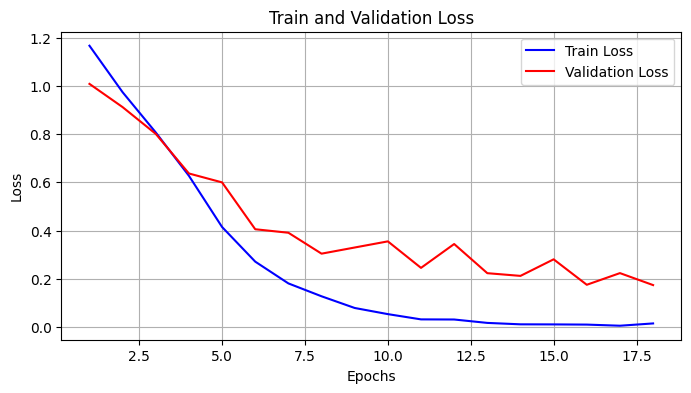

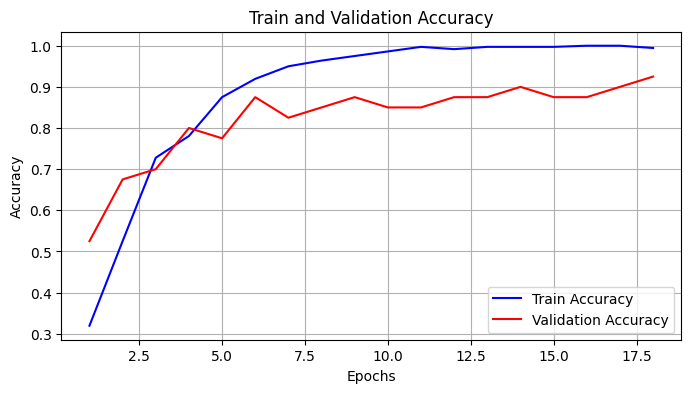

Training:  45%|████▌     | 27/60 [05:01<06:08, 11.16s/epoch, Elapsed Time=10.77s]


In [146]:
pretrain_model=train_model2(pretrain_model, train_loader,val_loader, optimizer, criterion, 60)
path="/content/drive/MyDrive/Dataset/model"
if not os.path.exists(path):
  os.makedirs(path)
else:
  pass
save_path = os.path.join(path, 'model5.pth')
torch.save(pretrain_model.state_dict(), save_path)

In [147]:
# pretrain_model = define_model()
# pretrain_model.load_state_dict(torch.load(save_path))

In [148]:
#Model evaluation on test set
def evaluate_model(model, test_loader):
    model.eval()
    total_predictions = 0
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy*100}%")

    return predicted_labels, true_labels


In [149]:
predicted, true_labels=evaluate_model(pretrain_model, test_loader)


Test Accuracy: 93.0%


In [150]:
#function to calculate accuracy, weighted precison, recall and f1 scores.
def calculate_performance(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1 {f1}')
    return

In [151]:

#Compute confusion matrix
def plot_confusion_matrix(predicted_labels, true_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    tick_labels = class_names if class_names else range(len(cm))
    ax.xaxis.set_ticklabels(tick_labels)
    ax.yaxis.set_ticklabels(tick_labels)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()


In [152]:
calculate_performance(predicted, true_labels)

accuracy: 0.93, precision: 0.930456081081081, recall: 0.93, f1 0.9300948366701792


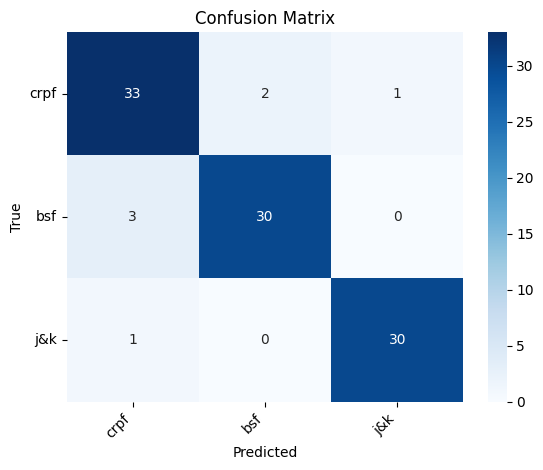

In [153]:
class_names=list(military.keys())
plot_confusion_matrix(predicted, true_labels, class_names )